In [1]:
import os
import yaml
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [2]:
year_range_maps = {
    # v2
    "era5_weekly_aurora_2000-2022-wb13-1h-240x121.zarr-v2": (2000, 2022),
    "era5_weekly_aurora_2010-2022-wb13-1h-240x121.zarr-v2": (2010, 2022),
    "era5_weekly_aurora_2020-2022-wb13-1h-240x121.zarr-v2": (2020, 2022),
    # v3
    "era5_weekly_aurora_2000-2022-wb13-1h-240x121.zarr-v3": (2000, 2022),
    "era5_weekly_aurora_2010-2022-wb13-1h-240x121.zarr-v3": (2010, 2022),
    "era5_weekly_aurora_2020-2022-wb13-1h-240x121.zarr-v3": (2020, 2022),
}

In [3]:
experiment_dir = "./experiments"

def parse_experiment(exp_dir):
    args_path = os.path.join(exp_dir, "args.yaml")
    times_summary_path = os.path.join(exp_dir, "times_summary.yaml")
    
    # get date as datetime
    try:
        date_str = os.path.basename(exp_dir).split("-")[1]
    except Exception as e:
        print(f"Error parsing date from {exp_dir}: {e}")
        return {}
    date = datetime.datetime.strptime(date_str, "%Y%m%dT%H%M%S")
    
    # Check if the required files exist
    if not os.path.exists(args_path):
        print(f"Warning: {args_path} does not exist. Experiment might not be complete.")
        return {}
    if not os.path.exists(times_summary_path):
        print(f"Warning: {times_summary_path} does not exist. Experiment might not be complete.")
        return {}
    
    # read args.yaml
    with open(os.path.join(exp_dir, "args.yaml"), "r") as f:
        args = yaml.safe_load(f)
    zarr_format = args.get("zarr_format", None)
    dataset = args.get("dataset", None)
    if os.path.exists(dataset): 
        source = "local"
        year_range = year_range_maps[os.path.basename(dataset)]
    else: 
        source = "gcs"
        date_range = args.get("date_range", None)
        year_range = (int(date_range[0].split("-")[0]), int(date_range[1].split("-")[0]))
    
    # read times_summary.yaml
    with open(os.path.join(exp_dir, "times_summary.yaml"), "r") as f:
        times_summary = yaml.safe_load(f)
    times = times_summary.get("times", None)
    
    return {
        "date": date,
        "zarr_format": zarr_format,
        "dataset": dataset,
        "source": source,
        "year_range": "-".join([str(y) for y in year_range]),
        "times": times,
        "id": "-".join([str(y) for y in year_range]) + f"\n{source}\nzarr-v{zarr_format}",
    }

experiment_data = []
for exp_dir in os.listdir(experiment_dir):
    exp_path = os.path.join(experiment_dir, exp_dir)
    print(f"Processing: {exp_path}")
    if not os.path.isdir(exp_path):
        continue
    
    # Parse the experiment directory
    data = parse_experiment(exp_path)
    if not data:
        continue
    experiment_data.append(data)

experiment_df = pd.DataFrame(experiment_data)
experiment_df.sort_values(by=["year_range"], ascending=False)

Processing: ./experiments/destroyed_rhythm-20250514T152347
Processing: ./experiments/jet_drum-20250514T152825
Processing: ./experiments/chasing_unicorn-20250514T152349
Processing: ./experiments/decisive_sander-20250514T152349
Processing: ./experiments/ivory_gelding-20250514T152349
Processing: ./experiments/uncanny_deer-20250514T152829


,date,zarr_format,dataset,source,year_range,times,id
0,2025-05-14 15:23:47,3,./data/era5_weekly_aurora_2020-2022-wb13-1h-24...,local,2020-2022,"[0.5396020412445068, 0.11922311782836914, 0.11...",2020-2022\nlocal\nzarr-v3
1,2025-05-14 15:28:25,2,gs://weatherbench2/datasets/era5_weekly/1959-2...,gcs,2020-2022,"[10.681475400924683, 11.714696407318115, 10.48...",2020-2022\ngcs\nzarr-v2
4,2025-05-14 15:23:49,2,./data/era5_weekly_aurora_2020-2022-wb13-1h-24...,local,2020-2022,"[0.47604894638061523, 0.07164359092712402, 0.0...",2020-2022\nlocal\nzarr-v2
5,2025-05-14 15:28:29,3,gs://weatherbench2/datasets/era5_weekly/1959-2...,gcs,2020-2022,"[11.710306644439697, 12.264936685562134, 10.42...",2020-2022\ngcs\nzarr-v3
2,2025-05-14 15:23:49,2,./data/era5_weekly_aurora_2010-2022-wb13-1h-24...,local,2010-2022,"[0.4302334785461426, 0.19700098037719727, 0.09...",2010-2022\nlocal\nzarr-v2
3,2025-05-14 15:23:49,2,./data/era5_weekly_aurora_2000-2022-wb13-1h-24...,local,2000-2022,"[0.6884329319000244, 0.2687370777130127, 0.259...",2000-2022\nlocal\nzarr-v2


## 

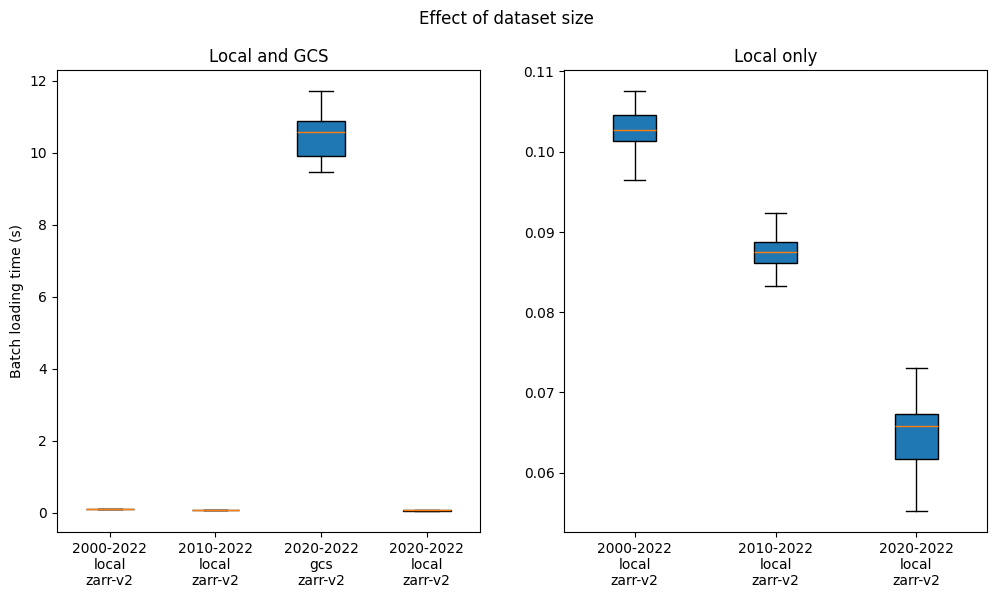

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Effect of dataset size")

sub = experiment_df.query("zarr_format == 2").sort_values(by=["year_range"])

axs[0].boxplot(
    [times for times in sub.times.values],
    tick_labels=[id_ for id_ in sub.id.values],
    showfliers=False,
    patch_artist=True,
)
axs[0].set_title("Local and GCS")
axs[0].set_ylabel("Batch loading time (s)")

sub = sub.query("source == 'local'")
axs[1].boxplot(
    [times for times in sub.times.values],
    tick_labels=[id_ for id_ in sub.id.values],
    showfliers=False,
    patch_artist=True,
)
axs[1].set_title("Local only")

plt.show()

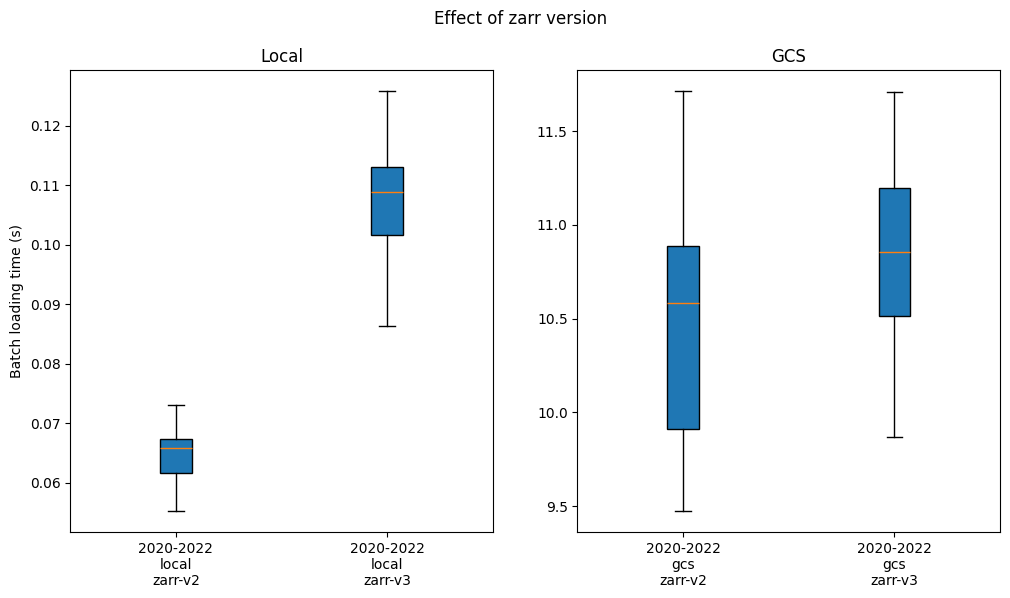

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Effect of zarr version")

sub = experiment_df.query("year_range == '2020-2022'").sort_values(by=["zarr_format"])

subsub = sub.query("source == 'local'")
axs[0].boxplot(
    [times for times in subsub.times.values],
    tick_labels=[id_ for id_ in subsub.id.values],
    showfliers=False,
    patch_artist=True,
)
axs[0].set_title("Local")
axs[0].set_ylabel("Batch loading time (s)")

subsub = sub.query("source == 'gcs'")
if not subsub.empty:
    axs[1].boxplot(
        [times for times in subsub.times.values],
        tick_labels=[id_ for id_ in subsub.id.values],
        showfliers=False,
        patch_artist=True,
    )
    axs[1].set_title("GCS")

plt.show()